<a href="https://colab.research.google.com/github/Sai0472003/PatentLitigation_Impact/blob/main/PROJECT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Patent Litigations Disparities: Who are the Real Winners and Losers?***

Research Question: How do  Litigation Outcomes impact the Profitibility and Reseach Investment of firms that are involved in Patent Lawsuits?

# ***Section 1: Introduction:***

Patent rights are crucial to society as they incentivize firms to invest in Research which yields improved living standards through increased innovation.
The process of exercissing patent rights via litigation, however, can be tedious and expensive.


 This paper seeks to explore disparities in firms' profitability and investment in research. This is done by looking at the difference in firms' Net Profit Margins and R&D to Revenue ratio, before and after being involved in a patent lawsuit. The Regression analysis is split between defendants and plaintiffs to better understand the disparities in both parties' outcomes.






# ***Section 2: Data Cleaning/Loading:***

In [173]:
#loading useful packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install stargazer
from stargazer.stargazer import Stargazer
from IPython.display import HTML



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
#loading csv's that have been a little precleaned and merged to avoid excessive
#lines of code for the cleaning section

#loading up csv's into Data Frames
merged_cases_FJC = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_cases_JFC.csv')
subset_plaintiff_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_npm.csv')
subset_defendent_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_npm.csv')
subset_plaintiff_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_RnD.csv')
subset_defendent_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_RnD.csv')

In [176]:
#creating plaintiff-only df with all the Y and X variables
#(no index or geospatial data)
plaintiffs_complete = pd.merge(subset_plaintiff_npm,
                               subset_plaintiff_RnD,
                               on=[
                                   "case_row_id", "disp_dismissed",
                                   "disp_settled", "disp_before_issue_joined",
                                   "infringement_35_271", "case_length",
                                   "info_tech", "health_care", "materials",
                                   "industrials", "consumer_discretionary"],
                               how = 'outer')

plaintiffs_complete['case_length'] = np.log(plaintiffs_complete['case_length'])

plaintiffs_complete = plaintiffs_complete.drop_duplicates()
plaintiffs_complete = plaintiffs_complete[[
                            "delta_npm", "delta_rnd_sales","disp_dismissed",
                            "disp_settled", "disp_before_issue_joined",
                            "infringement_35_271", "case_length", "info_tech",
                            "health_care"
                             ]]

In [177]:
plaintiffs_complete.head()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,case_length,info_tech,health_care
0,NaN,0.009418,0.0,0.0,0.0,0.0,1.885390,0,0
1,-0.056082,NaN,0.0,0.0,0.0,0.0,6.588926,0,0
2,NaN,0.005320,0.0,0.0,1.0,0.0,1.524995,1,0
3,-0.061502,NaN,0.0,0.0,1.0,0.0,4.595120,1,0
4,NaN,0.017003,1.0,1.0,1.0,1.0,1.653598,0,1


In [178]:
#creating defendent-only df with all the Y and X variables,
#(no index or geospatial data)
defendents_complete = pd.merge(subset_defendent_npm,
                               subset_defendent_RnD,
                               on=[
                                   "case_row_id", "disp_dismissed",
                                   "disp_settled", "disp_before_issue_joined",
                                   "infringement_35_271", "case_length",
                                   "info_tech", "health_care", "materials",
                                   "industrials", "consumer_discretionary"],
                               how = 'outer')

defendents_complete = defendents_complete.drop_duplicates()
defendents_complete = defendents_complete[[
                            "delta_npm", "delta_rnd_sales","disp_dismissed",
                            "disp_settled", "disp_before_issue_joined",
                            "infringement_35_271", "case_length", "info_tech",
                            "health_care"
                             ]]

In [179]:
defendents_complete.head()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,case_length,info_tech,health_care
0,-0.523178,0.043103,1.0,0.0,1.0,0.0,6.169611,0,0
1,-0.002907,0.000000,1.0,1.0,0.0,0.0,6.350886,0,0
2,0.004274,0.005925,1.0,1.0,0.0,0.0,6.037871,0,0
3,0.001192,-0.000766,1.0,1.0,1.0,1.0,5.484797,0,0
4,0.013409,-0.003403,1.0,1.0,1.0,1.0,5.123964,0,1


**Data Sources:**
The data above are from the Assigned Kaggle Source, the Integrated Database of the Federal Judicial Center(FJC) and Finantial Data of publicly listed firms from the Compustat Database maintained by Wharton Research Data Services(WRDS). The FJC source added case outcomes such as whether ir was dismissed, went to judgment, settled etc. and the Compustat source added Financial data as well as GICS industry classifications. The merging process isnt shown as it was extremely long and included sending SQL queries to Compustat, Creating Dummies through complex processes(owing to structure of raw data) and matching financial data for firms with right timeline. The financial data from Compustat was of Quarterly Frequency and thus was matched based on the quarter of case filing and quarter of case closing, and cases that didn't span two distinct financial quarters were filtered out.



**Explanation of the Variables:**

Both dataframes defendents_complete and plaintiffs_complete conatain the same variables, for each unique case that was matched with WRDS dataset of publicly traded firms. The unit of observation is unique patent cases in both.

delta_npm: change in firm's net profit margin (0.01 = 1 percentage point)

delta_rnd_sales: change in firm's R&D to sales Ratio (0.01 = 1 percentage point)

disp_dismissed: dummy indicating whether a case was dismissed(reference represents cases that were resolved via judgment)

disp_settled: dummy that indicates if a case was dismissed, involved a settlement(this is only for rows where disp_dismissed = 1)

disp_before_issue_joined: dummy that indicates whether a case was dismissed before issue was joined(this means no legal proceedings were actually conducted between the case's filing and dismisssal, also only for rows with disp_dismissed = 1 )

infringement_35_271: dummy that indicates whether a case was filed Under 35 U.S.C. § 271(this essentially means that direct patent infringement was alleged by plaintiff)

case_length: the natural log of total days between a case's filing and closing(this variable has an extreme right skew, thus a natural log was applied)

info_tech: a dummy that indicates whether a given firm is classied as part of the information technology sector, under the GICS sector classification system(the reference category is all firms not in the info-tech sector)

health_care: a dummy that indicates whether a given firm is classied as part of the healthcare sector, under the GICS sector classification system(the reference category is all firms not in the info-tech sector)

Only two dummies for sector fixed effects were used because other sectors had very few occurrences in the merged dataset.

# ***Section 3: Summary Statistics:***

In [180]:
plaintiffs_complete.describe()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,case_length,info_tech,health_care
count,1147.000000,1157.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,8.741107,-0.764724,0.733941,0.619358,0.280816,0.517361,3.809284,0.394531,0.258681
std,184.206505,82.468427,0.441991,0.485650,0.449495,0.499807,2.172286,0.488856,0.438005
min,-348.520087,-1273.693333,0.000000,0.000000,0.000000,0.000000,1.113344,0.000000,0.000000
25%,-0.033832,-0.003042,0.000000,0.000000,0.000000,0.000000,1.780849,0.000000,0.000000
50%,-0.000521,0.000473,1.000000,1.000000,0.000000,1.000000,2.081004,0.000000,0.000000
75%,0.025305,0.010271,1.000000,1.000000,1.000000,1.000000,5.935555,1.000000,1.000000
max,3594.053333,1212.250000,1.000000,1.000000,1.000000,1.000000,8.343078,1.000000,1.000000


Based on the summary stats for the plaintiffs, we can see that there is a strong right skew in the delta_npm. delta_rnd_sales aseems normally distributed around 0.

The case_length has already been logged, due to a large skew. It appears to be fairly evenly distributed betwen the range of 1 to 8.

The cateogrorical variables all appear to be evenly ditributed between 0 and 1.

In [181]:
defendents_complete.describe()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,case_length,info_tech,health_care
count,2557.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000
mean,-0.079224,0.013422,0.816335,0.604533,0.418132,0.633060,5.586478,0.148105,0.386088
std,3.238747,0.720413,0.387287,0.489046,0.493349,0.482064,0.966466,0.355273,0.486946
min,-152.326629,-7.251561,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000
25%,-0.019312,-0.001439,1.000000,0.000000,0.000000,0.000000,4.863673,0.000000,0.000000
50%,0.001188,0.000000,1.000000,1.000000,0.000000,1.000000,5.583496,0.000000,0.000000
75%,0.021006,0.003631,1.000000,1.000000,1.000000,1.000000,6.309005,0.000000,1.000000
max,18.700229,31.787848,1.000000,1.000000,1.000000,1.000000,8.628019,1.000000,1.000000


Looking at the summary statistics for the defendants, we see that both the outcome variables are distributed around 0 but delta_npm appears to have a strong negative skew while delta_rnd_sales has strong positive skew. This could be an indication that litigatoin tends to lower defendants' profit margins but in some instances, leads to increase in research spending.

The categories once again seem evenly distributed with th exception of a larger proportion of 0s in disp_before_issue_joined.

Overall no major issues in both sets of plaintiff and defendant data, except for the skew inside the delta_npm variables

# ***Section 4: Data Visualizations:***

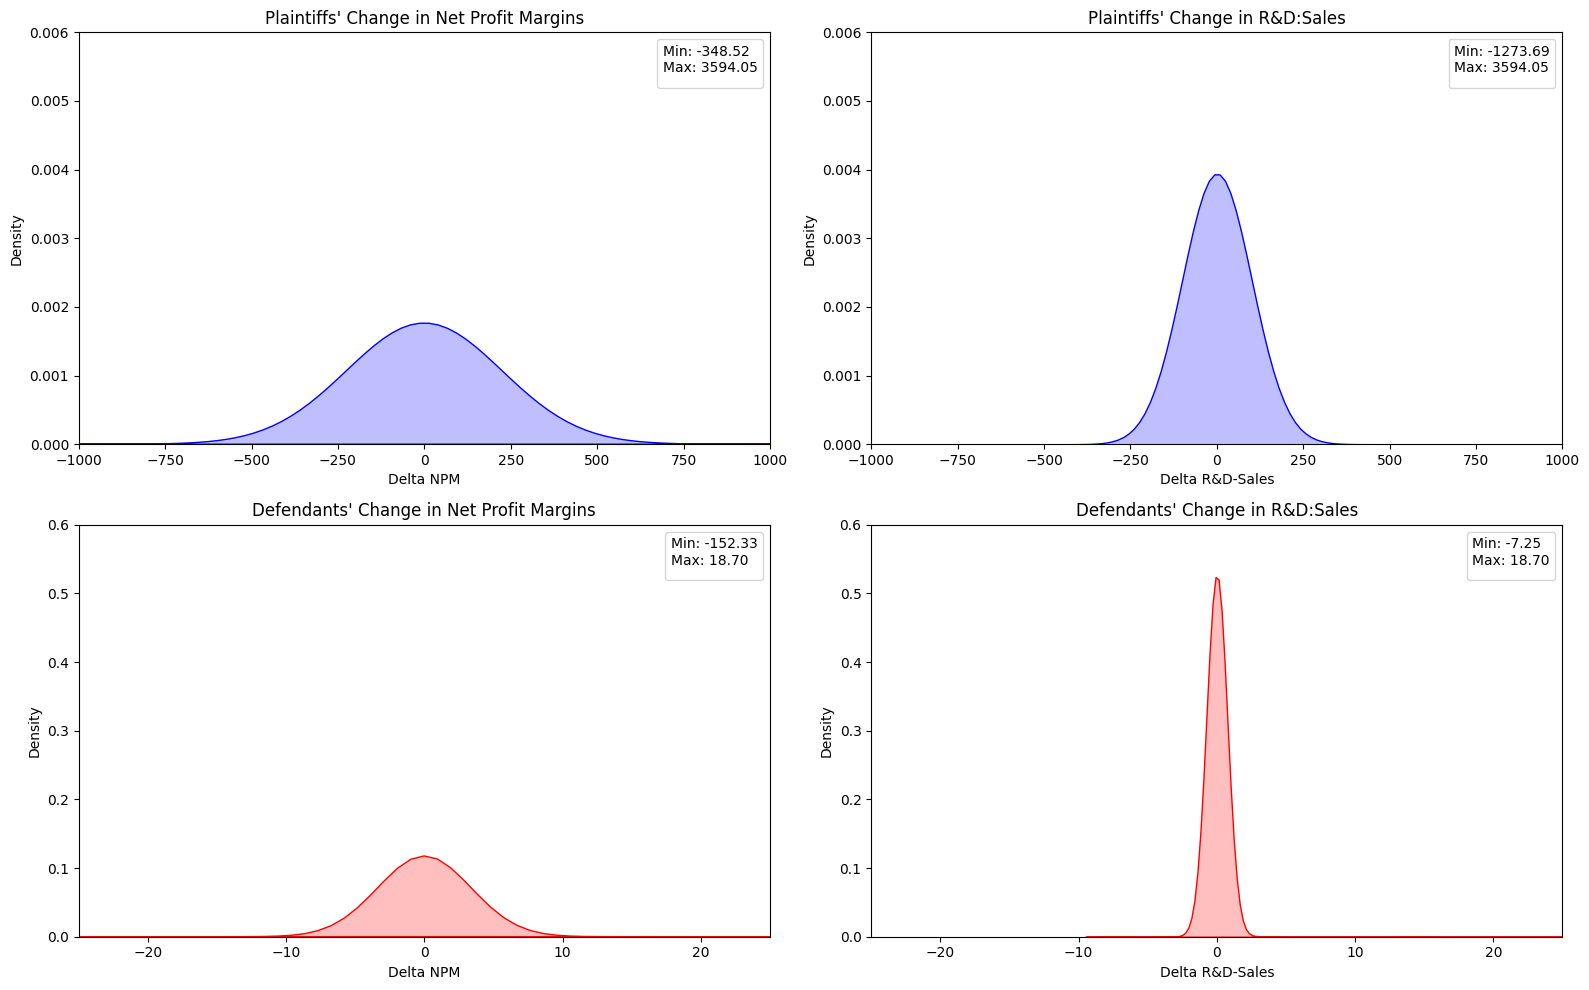

In [182]:
# Density plots for NPM and RnD:Sales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot KDE for plaintiffs NPM
sns.kdeplot(plaintiffs_complete["delta_npm"],
            fill=True, color="blue", ax=axes[0,0],bw_adjust=5)
axes[0,0].set_title("Plaintiffs' Change in Net Profit Margins")
axes[0,0].set_xlabel("Delta NPM")
axes[0,0].set_ylabel("Density")
axes[0,0].grid(False)

# Plot KDE for defendants NPM
sns.kdeplot(defendents_complete["delta_npm"],
            fill=True, color="red", ax=axes[1,0],bw_adjust=5)
axes[1,0].set_title("Defendants' Change in Net Profit Margins")
axes[1,0].set_xlabel("Delta NPM")
axes[1,0].grid(False)

# Plot KDE for plaintiffs Rnd
sns.kdeplot(plaintiffs_complete["delta_rnd_sales"],
            fill=True, color="blue", ax=axes[0,1], bw_adjust=5)
axes[0,1].set_title("Plaintiffs' Change in R&D:Sales")
axes[0,1].set_xlabel("Delta R&D-Sales")
axes[0,1].set_ylabel("Density")
axes[0,1].grid(False)

# Plot KDE for defendants Rnd
sns.kdeplot(defendents_complete["delta_rnd_sales"],
            fill=True, color="red", ax=axes[1,1],bw_adjust=5)
axes[1,1].set_title("Defendants' Change in R&D:Sales")
axes[1,1].set_xlabel("Delta R&D-Sales")
axes[1,1].grid(False)


# Add min and max values as text legend
axes[0,0].legend(
    handles=[],
    title=f"Min: {plaintiffs_complete['delta_npm'].min():.2f}\nMax: {plaintiffs_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[1,0].legend(
    handles=[],
    title=f"Min: {defendents_complete['delta_npm'].min():.2f}\nMax: {defendents_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[0,1].legend(
    handles=[],
    title=f"Min: {plaintiffs_complete['delta_rnd_sales'].min():.2f}\nMax: {plaintiffs_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[1,1].legend(
    handles=[],
    title=f"Min: {defendents_complete['delta_rnd_sales'].min():.2f}\nMax: {defendents_complete['delta_npm'].max():.2f}",
    loc="upper right")



#zooming into the peaks
axes[0,0].set_ylim(0, 0.006)
axes[0,0].set_xlim(-1000, 1000)
axes[1,0].set_ylim(0, 0.6)
axes[1,0].set_xlim(-25, 25)
axes[0,1].set_ylim(0, 0.006)
axes[0,1].set_xlim(-1000, 1000)
axes[1,1].set_ylim(0, 0.6)
axes[1,1].set_xlim(-25, 25)

plt.tight_layout()
plt.show()

The above figure illusutrates the Kernel Density Estimated distributions for the outcome variables, for plaintiffs and defendants.

We observe that Profit Margins have considerable smaller peaks and larger spreads, relative to R&D sales. All four appear normally distributed around zero, but in reality they are all heavily skewed, the visualizes simply zooms in to focus on the peaks.

Additionally, the distributions of changes in NPM and the R&D/sales ratio for defendants, appear to gave much lower spread compared to their plaintiff counterparts and the distributions of R&D change are much narrower than those of Net Profit Marings.

The skews, aren't entirely visible but denoted via the Max and Min values. We observe that for Net Profit Margins, the defendants have a left skew while plaintiffs have a strong right skew. This demonstrates disparities in outcomes, defendants tend to have decreases in profit margins while plaintiffs have increases.

We also observe that the R&D distributions for both plaintiffs and defendents are both skewed to the right, however, platintiffs' tail is considerably larger than the defendants.

In [183]:
plaintiffs_complete['delta_rnd_sales'].isna().sum()

np.int64(1147)

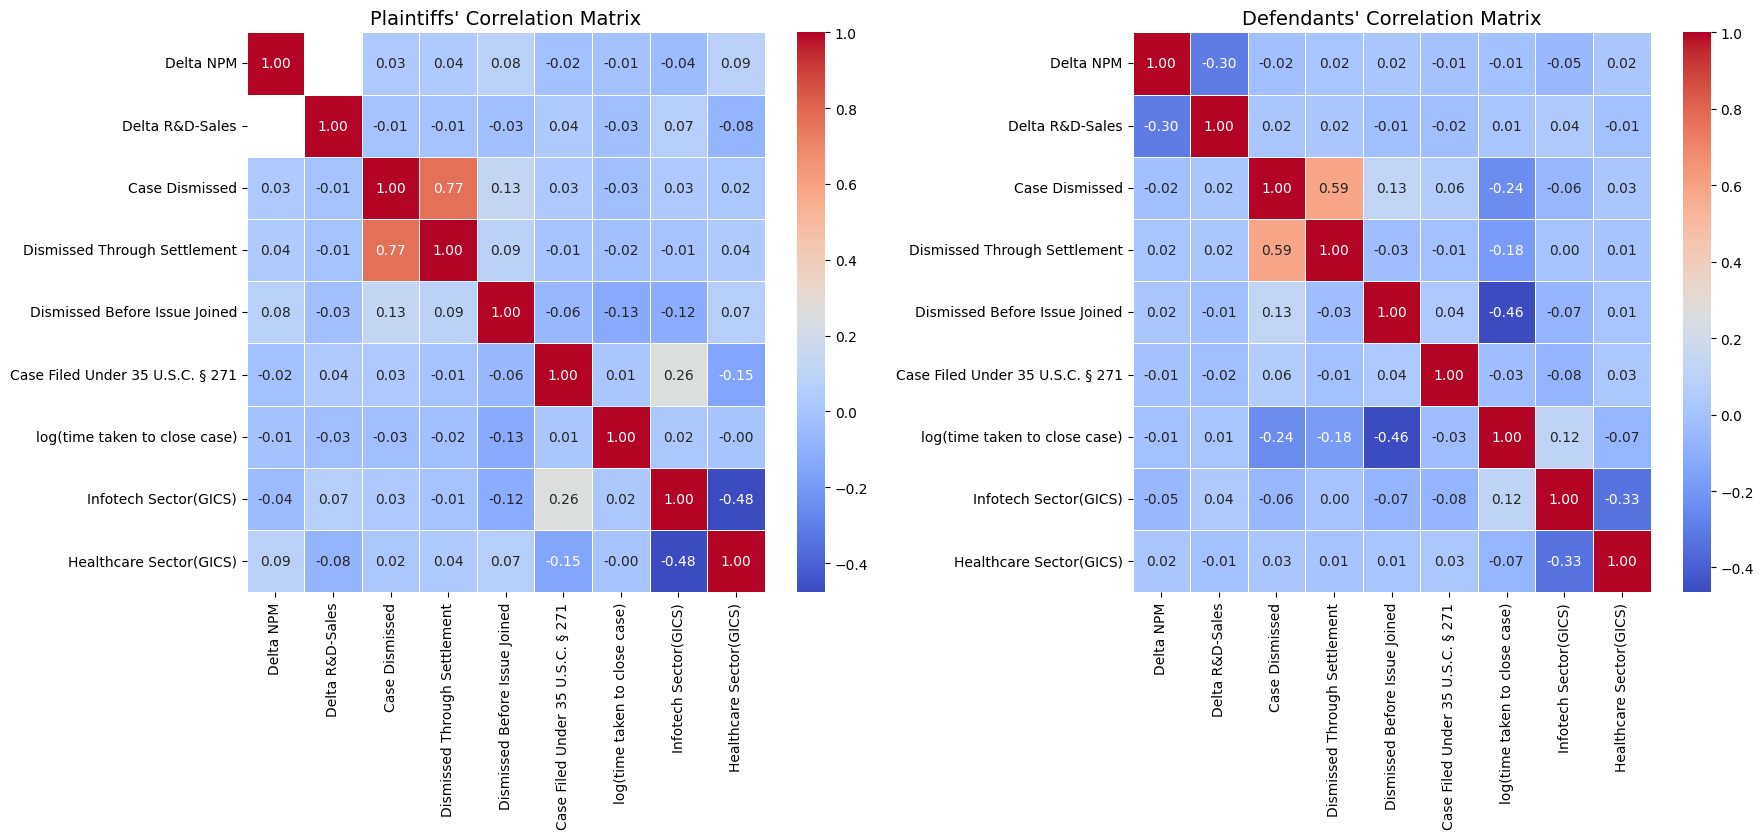

In [184]:
# Compute correlation matrices
corr_matrix_plt = plaintiffs_complete[[
    'delta_npm', 'delta_rnd_sales', 'disp_dismissed', 'disp_settled',
    'disp_before_issue_joined', 'infringement_35_271', 'case_length',
    'info_tech', 'health_care'
    ]].corr()
corr_matrix_def = defendents_complete[[
    'delta_npm', 'delta_rnd_sales', 'disp_dismissed', 'disp_settled',
    'disp_before_issue_joined','infringement_35_271', 'case_length',
    'info_tech', 'health_care'
    ]].corr()

# Rename labels using the provided mapping
label_mapping = {
    "delta_npm": "Delta NPM",
    "delta_rnd_sales": "Delta R&D-Sales",
    "disp_dismissed": "Case Dismissed",
    "disp_settled": "Dismissed Through Settlement",
    "disp_before_issue_joined": "Dismissed Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to close case)",
    "info_tech": "Infotech Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"
}

# Apply clean labels
corr_matrix_plt = corr_matrix_plt.rename(columns=label_mapping, index=label_mapping)
corr_matrix_def = corr_matrix_def.rename(columns=label_mapping, index=label_mapping)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))  # Increase size for clarity

# Plot for Plaintiffs
sns.heatmap(corr_matrix_plt, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Plaintiffs' Correlation Matrix", fontsize=14)
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
axes[0].tick_params(axis='y', rotation=0)   # Keep y-axis labels straight

# Plot for Defendants
sns.heatmap(corr_matrix_def, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Defendants' Correlation Matrix", fontsize=14)
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

The Correlation Matries show, similar small and negative correlations between the variables

# ***Section 5: The Message:***

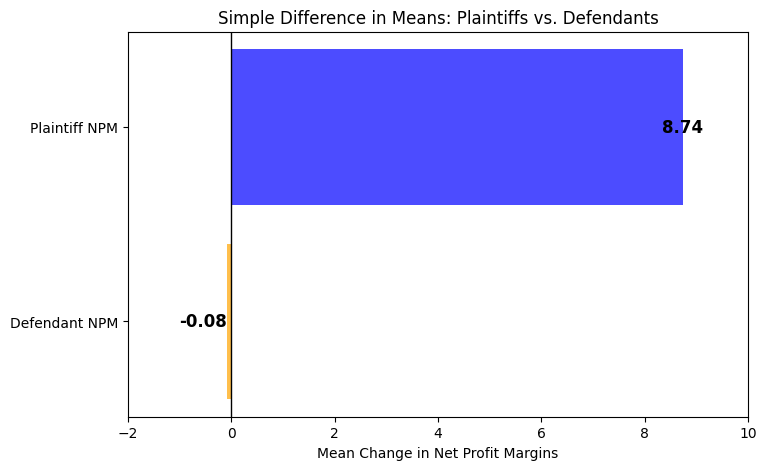

In [185]:
# Compute means
mean_plaintiff = plaintiffs_complete["delta_npm"].mean()
mean_defendant = defendents_complete["delta_npm"].mean()

# Define categories and means
categories = ["Defendant NPM", "Plaintiff NPM"]  # Defendant first so negative is on the left
means = [mean_defendant, mean_plaintiff]  # Order matters!

# Create the horizontal bar plot
plt.figure(figsize=(8, 5))
plt.barh(categories, means, color=["orange", "blue"], alpha=0.7)

# Annotate mean values on bars
for i, mean in enumerate(means):
    plt.text(mean, i, f"{mean:.2f}", ha="center" if mean > 0 else "right",
             va="center", fontsize=12, fontweight="bold", color="black")

# Improve readability
plt.axvline(0, color="black", linewidth=1)  # Add vertical line at x=0 for reference
plt.xlabel("Mean Change in Net Profit Margins")
plt.title("Simple Difference in Means: Plaintiffs vs. Defendants")
plt.xlim(-2,10)

# Show plot
plt.show()


**The Message:** Significant disparities exist between firms that sue over patent rights and firms that are being sued.



**Interpretation of the Figure:**
Plaintiffs are observed to have a 874 percentage point increase(0.01 = 1 percent point) in profit margins, on average, whereas Defendents are observed to have a 8 percentage point decrease in their profit margins, on average. This effectively summarizes the existance of disparities; Plaintiffs that bring legal action based on patent rights, tend to profit significantly while defendents are observed to have declined profitability.

# ***Section 6: Maps:***

In [186]:
#loading up a precleaned gdf to reduce amount of cleaning code displayedx
map_gdf = gpd.read_file('/content/drive/My Drive/ECO225_Final_Project/DATA/cleaned_data.gpkg')

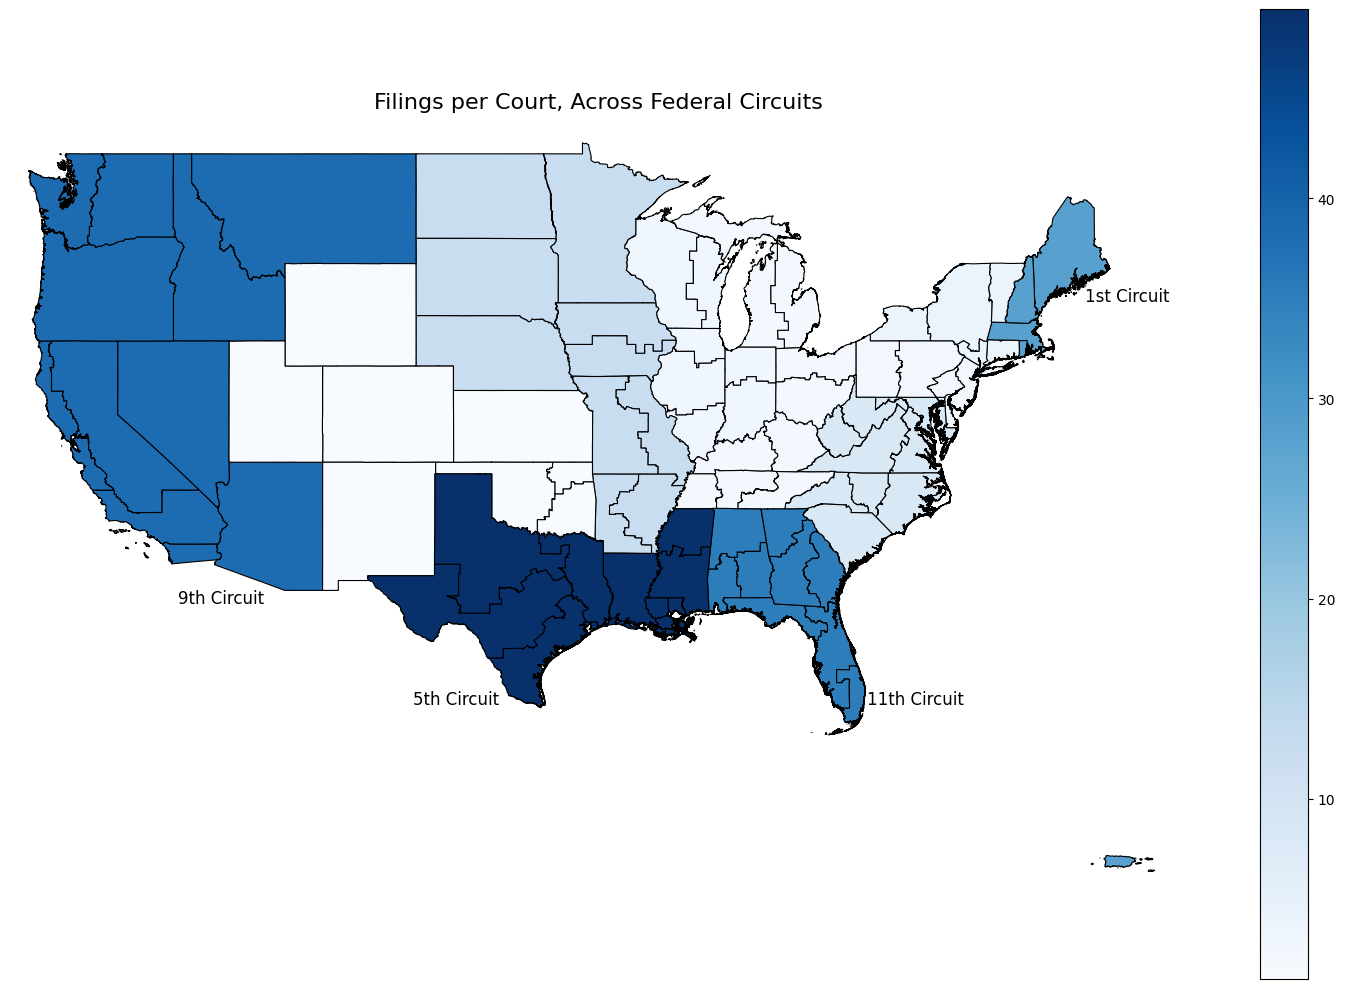

In [187]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="filings_per_court",
             cmap="Blues",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Filings per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')

plt.tight_layout()
plt.show()

The map above portrays the number of patent case/filings from

In [188]:
#Manually Mapping out the number codes into district court names for merging :(
court_mapping = {
    "00": "Maine District Court",
    "01": "Massachusetts District Court",
    "02": "New Hampshire District Court",
    "03": "Rhode Island District Court",
    "04": "Puerto Rico District Court",
    "05": "Connecticut District Court",
    "06": "New York Northern District Court",
    "07": "New York Eastern District Court",
    "08": "New York Southern District Court",
    "09": "New York Western District Court",
    "10": "Vermont District Court",
    "11": "Delaware District Court",
    "12": "New Jersey District Court",
    "13": "Pennsylvania Eastern District Court",
    "14": "Pennsylvania Middle District Court",
    "15": "Pennsylvania Western District Court",
    "16": "Maryland District Court",
    "17": "North Carolina Eastern District Court",
    "18": "North Carolina Middle District Court",
    "19": "North Carolina Western District Court",
    "20": "South Carolina District Court",
    "22": "Virginia Eastern District Court",
    "23": "Virginia Western District Court",
    "24": "West Virginia Northern District Court",
    "25": "West Virginia Southern District Court",
    "26": "Alabama Northern District Court",
    "27": "Alabama Middle District Court",
    "28": "Alabama Southern District Court",
    "29": "Florida Northern District Court",
    "3A": "Florida Middle District Court",
    "3C": "Florida Southern District Court",
    "3E": "Georgia Northern District Court",
    "3G": "Georgia Middle District Court",
    "3J": "Georgia Southern District Court",
    "3L": "Louisiana Eastern District Court",
    "3N": "Louisiana Middle District Court",
    "36": "Louisiana Western District Court",
    "37": "Mississippi Northern District Court",
    "38": "Mississippi Southern District Court",
    "39": "Texas Northern District Court",
    "40": "Texas Eastern District Court",
    "41": "Texas Southern District Court",
    "42": "Texas Western District Court",
    "43": "Kentucky Eastern District Court",
    "44": "Kentucky Western District Court",
    "45": "Michigan Eastern District Court",
    "46": "Michigan Western District Court",
    "47": "Ohio Northern District Court",
    "48": "Ohio Southern District Court",
    "49": "Tennessee Eastern District Court",
    "50": "Tennessee Middle District Court",
    "51": "Tennessee Western District Court",
    "52": "Illinois Northern District Court",
    "53": "Illinois Central District Court",
    "54": "Illinois Southern District Court",
    "55": "Indiana Northern District Court",
    "56": "Indiana Southern District Court",
    "57": "Wisconsin Eastern District Court",
    "58": "Wisconsin Western District Court",
    "60": "Arkansas Eastern District Court",
    "61": "Arkansas Western District Court",
    "62": "Iowa Northern District Court",
    "63": "Iowa Southern District Court",
    "64": "Minnesota District Court",
    "65": "Missouri Eastern District Court",
    "66": "Missouri Western District Court",
    "67": "Nebraska District Court",
    "68": "North Dakota District Court",
    "69": "South Dakota District Court",
    "70": "Arizona District Court",
    "71": "California Northern District Court",
    "72": "California Eastern District Court",
    "73": "California Central District Court",
    "74": "California Southern District Court",
    "75": "Hawaii District Court",
    "76": "Idaho District Court",
    "77": "Montana District Court",
    "78": "Nevada District Court",
    "79": "Oregon District Court",
    "80": "Washington Eastern District Court",
    "81": "Washington Western District Court",
    "82": "Colorado District Court",
    "83": "Kansas District Court",
    "84": "New Mexico District Court",
    "85": "Oklahoma Northern District Court",
    "86": "Oklahoma Eastern District Court",
    "87": "Oklahoma Western District Court",
    "88": "Utah District Court",
    "89": "Wyoming District Court",
    "90": "District of Columbia District Court",
    "91": "Virgin Islands District Court",
    "92": "Guam District Court",
    "94": "Northern Mariana Islands District Court",
    "-8": None  # Missing value
}



circuit_mapping = {
    "0": "District of Columbia Circuit",
    "01": "First Circuit",
    '02': "Second Circuit",
    '03': "Third Circuit",
    '04': "Fourth Circuit",
    '05': "Fifth Circuit",
    '06': "Sixth Circuit",
    '07': "Seventh Circuit",
    '08': "Eighth Circuit",
    '09': "Ninth Circuit",
    '10': "Tenth Circuit",
    '11': "Eleventh Circuit",
    'DC': "District of Columbia Circuit",
    '-8': None  # Missing value case
}


merged_cases_FJC["DISTRICT"] = merged_cases_FJC["DISTRICT"].astype(str).map(court_mapping)

In [189]:
#plotting average dismissals/court by Circuits
map_disposals = merged_cases_FJC.groupby("DISTRICT").agg({
    "disp_dismissed": "sum",
    "disp_settled": "sum",
    "disp_before_issue_joined": "sum"})

map_disposals = map_disposals.reset_index()
map_gdf = pd.merge(map_gdf, map_disposals, left_on="NAME" ,right_on="DISTRICT", how="left")

map_gdf['circuit_dismissed'] = map_gdf.groupby("Circuit")["disp_dismissed"].transform('sum')
map_gdf['dismissals_per_court'] = map_gdf['circuit_dismissed']/map_gdf['num_district_courts']

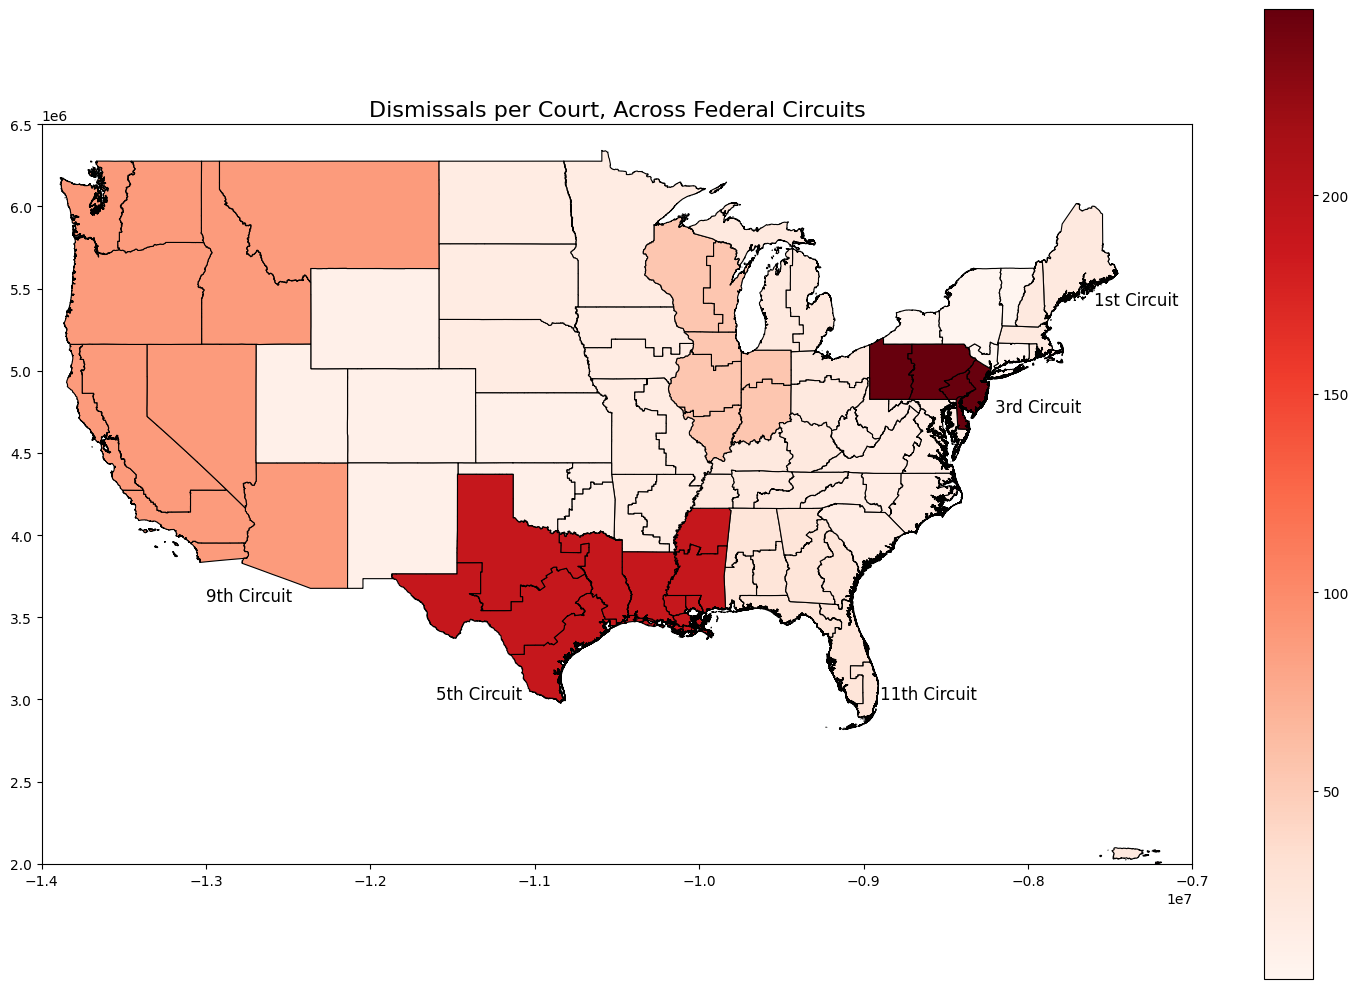

In [190]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="dismissals_per_court",
             cmap="Reds",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Dismissals per Court, Across Federal Circuits", fontsize=16)
#ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')
ax.annotate("3rd Circuit", xy=(-0.82e7, 4.75e6), fontsize=12, color='black')


plt.tight_layout()
plt.show()

In [191]:
map_gdf['circuit_disp_issue_joined'] = map_gdf.groupby("Circuit")["disp_before_issue_joined"].transform('sum')
map_gdf['dismissals_before_issue'] = (map_gdf['circuit_disp_issue_joined']/map_gdf['circuit_dismissed'])/map_gdf['num_district_courts']

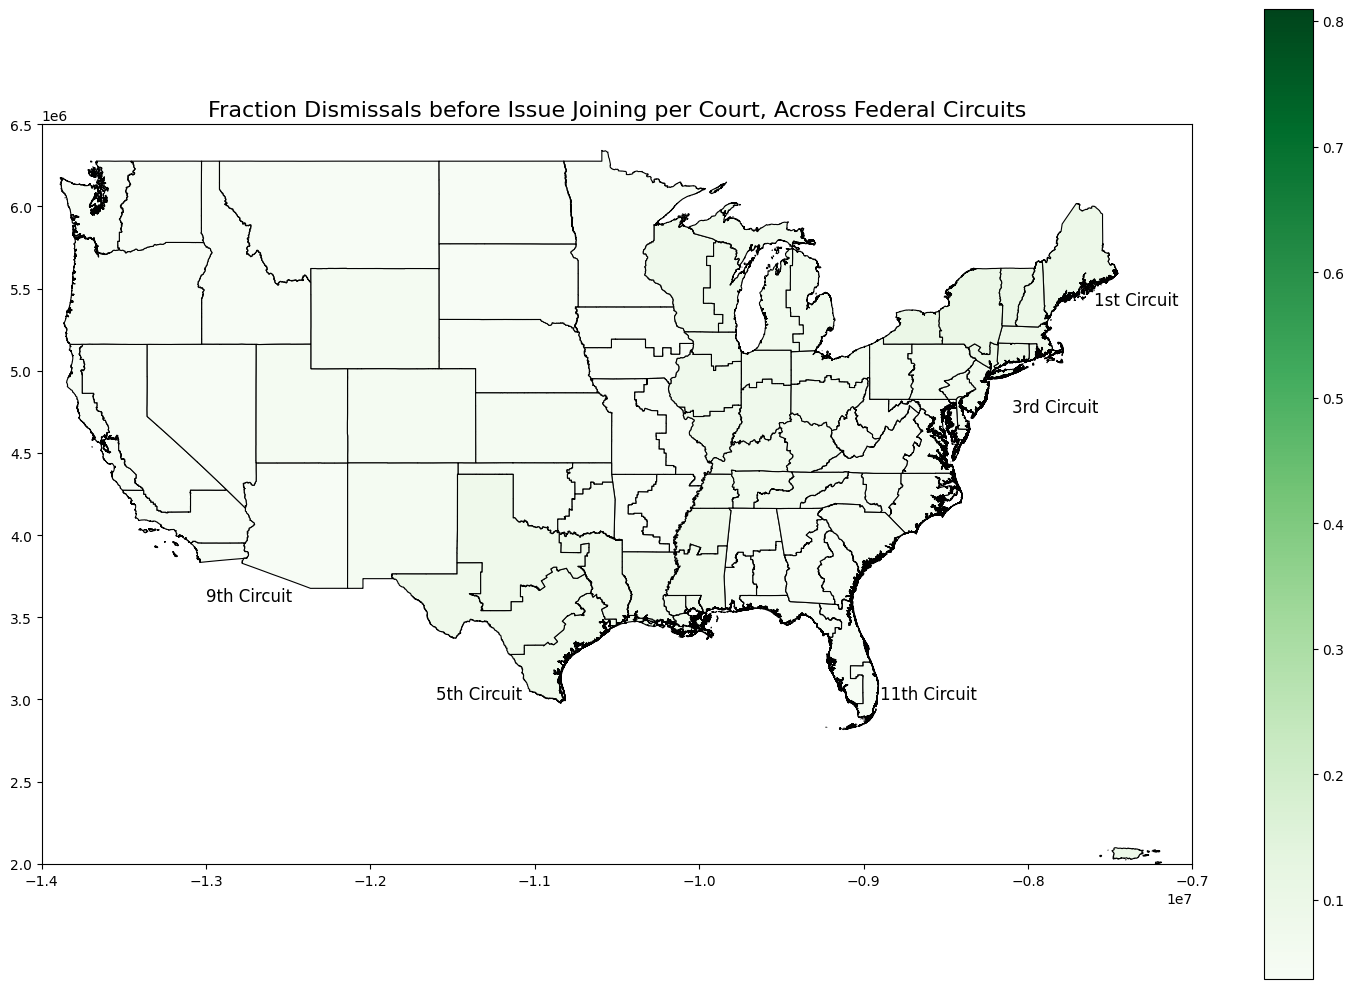

In [192]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="dismissals_before_issue",
             cmap="Greens",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Fraction Dismissals before Issue Joining per Court, Across Federal Circuits", fontsize=16)
#ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')
ax.annotate("3rd Circuit", xy=(-0.81e7, 4.75e6), fontsize=12, color='black')


plt.tight_layout()
plt.show()

# ***Section 7: Regressions:***

In [193]:
# Regression Table 1.1: The imapct of Case Disposals on Net Profit Margins[Defendents]

#base model
model1_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_defendent_npm).fit()
#includes interactions
model2_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=subset_defendent_npm).fit()
#includes interactions and case cause and length
model3_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_defendent_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_defendent_npm).fit()


#The imapct of Case Disposals on Net Profit Margins[Plaintiffs]

#based model
model1_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_plaintiff_npm).fit()
#includes interactions
model2_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=subset_plaintiff_npm).fit()
#includes interactions and case cause and length
model3_p = smf.ols('delta_npm ~ disp_dismissed+ disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_plaintiff_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_plaintiff_npm).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined", "infringement_35_271",
                            "case_length", "info_tech", "health_care"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed:Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed:Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Information Technology Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Net Profit Margins")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

In [194]:
# Regression Table 2.1: The imapct of Case Disposals on RnD-Sales Ratio[Defendent]

#base model
model1_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_defendent_RnD).fit()
#includes interactions
model2_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=subset_defendent_RnD).fit()
#includes interactions and case cause
model3_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_defendent_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_defendent_RnD).fit()


# Regression Table 2.2: The imapct of Case Disposals on RnD-Sales Ratio[Plaintiffs]

#based model
model1_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_plaintiff_RnD).fit()
#includes interactions
model2_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=subset_plaintiff_RnD).fit()
#includes interactions and case cause
model3_p = smf.ols('delta_rnd_sales ~ disp_dismissed+ disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_plaintiff_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_plaintiff_RnD).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined", "infringement_35_271",
                            "case_length",  "info_tech", "health_care"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed:Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed:Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Information Technology Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Change in R&D to Sales Ratio")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

# ***Section 8: Conclusion:***